## CycleGAN 논문 코드 구현 및 실험

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
from google.colab import drive
import glob
import matplotlib.pyplot as plt
import torchvision
from torchinfo import summary
from torchsummary import summary as summary_
from time import time
import PIL
import shutil

In [4]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
#0~764까지 남자 그 이후로 여자

'969'

In [33]:
os.makedirs('/content/drive/MyDrive/it_snotme/girl_dir')
os.makedirs('/content/drive/MyDrive/it_snotme/man_dir')

In [36]:
origin_dir = '/content/drive/MyDrive/it_snotme'
man_root = '/content/drive/MyDrive/it_snotme/man_dir'
woman_root = '/content/drive/MyDrive/its_notme/girl_dir'

In [ ]:
for i in range(100):
  print(os.listdir(origin_dir)[i][3:-5])

In [71]:
for i in range(len(os.listdir(origin_dir))):
  try:

    if float(os.listdir(origin_dir)[i][3:-5]) <= 764:

      shutil.move(origin_dir + '/' + os.listdir(origin_dir)[i], man_root)
    else:
      shutil.move(origin_dir + '/' + os.listdir(origin_dir)[i], woman_root)
  except:
    pass

In [72]:
print(len(os.listdir(man_root)))
print(len(os.listdir(woman_root)))

669
718


In [73]:
man_img_list = []
for i in range(64):
  man_img = Image.open(man_root + '/'+os.listdir(man_root)[i])
  man_img = np.array(man_img)
  man_img_list.append(man_img)

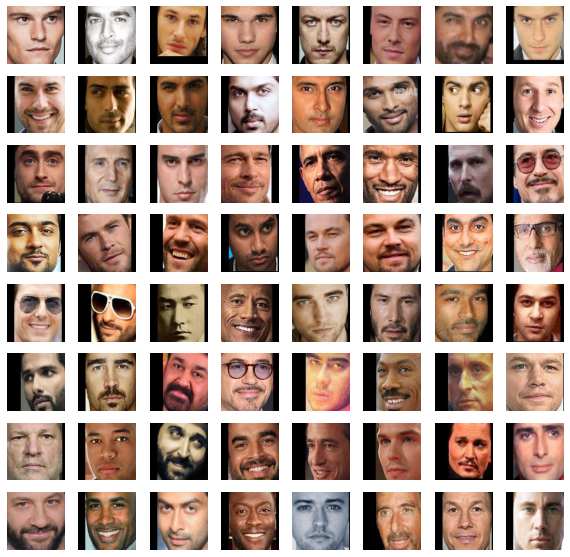

In [75]:
plt.figure(figsize = (10, 10))
for i in range(1, 65):
  plt.subplot(8, 8, i)
  plt.imshow(man_img_list[i-1])
  plt.axis('off')

In [78]:
man_img_list[0].shape

(480, 480, 3)

In [76]:
woman_img_list = []
for i in range(64):
  woman_img = Image.open(woman_root + '/'+os.listdir(woman_root)[i])
  woman_img = np.array(woman_img)
  woman_img_list.append(woman_img)

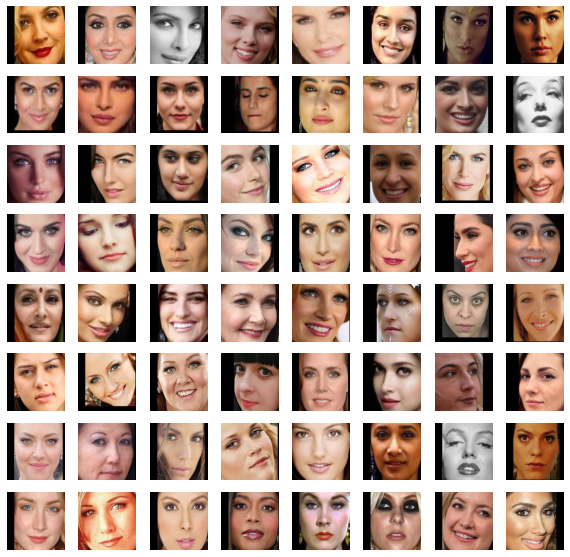

In [79]:
plt.figure(figsize = (10, 10))
for i in range(1, 65):
  plt.subplot(8, 8, i)
  plt.imshow(woman_img_list[i-1])
  plt.axis('off')

In [80]:
woman_img_list[0].shape

(480, 480, 3)

## Layer들 정의

In [81]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(Block, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias = True, padding_mode = 'reflect'),
        nn.InstanceNorm2d(out_channels), #batch 단위로 정규화아닌 instance 개개인으로 정규화화
        nn.LeakyReLU(0.2)
    )
  def forward(self, x):
    return self.conv(x)

In [82]:
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super(Discriminator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels, features[0], kernel_size = 4, stride = 2, padding = 1, padding_mode ='reflect'), # Conv(3, 64, 4, 2, 1)
    nn.LeakyReLU(0.2))

    layers = []
    in_channels = features[0] # 64
    for feature in features[1:]:
      layers.append(Block(in_channels, feature, stride = 1 if feature == features[-1] else 2)) #Conv(64,128, 4, 2, 1),Conv(128,256, 4, 2, 1), Conv(256, 512, 4, 1, 1)  담는다
      in_channels = feature #feature를 다음 in_channels 로 넘겨준다
    layers.append(nn.Conv2d(in_channels,1, kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect')) #Conv(512, 1, 4, 1, 1)
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    x = self.initial(x) # 256 -> 128
    return torch.sigmoid(self.model(x)) # 30 x 30 pathgan

In [83]:
x = torch.randn((5, 3, 256, 256))
model = Discriminator(in_channels = 3)
preds = model(x)
print(preds.shape)

torch.Size([5, 1, 30, 30])


In [84]:
mod = model.to(device)
summary_(mod, (3, 256, 256), batch_size = 5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [5, 64, 128, 128]           3,136
         LeakyReLU-2          [5, 64, 128, 128]               0
            Conv2d-3           [5, 128, 64, 64]         131,200
    InstanceNorm2d-4           [5, 128, 64, 64]               0
         LeakyReLU-5           [5, 128, 64, 64]               0
             Block-6           [5, 128, 64, 64]               0
            Conv2d-7           [5, 256, 32, 32]         524,544
    InstanceNorm2d-8           [5, 256, 32, 32]               0
         LeakyReLU-9           [5, 256, 32, 32]               0
            Block-10           [5, 256, 32, 32]               0
           Conv2d-11           [5, 512, 31, 31]       2,097,664
   InstanceNorm2d-12           [5, 512, 31, 31]               0
        LeakyReLU-13           [5, 512, 31, 31]               0
            Block-14           [5, 512,

In [85]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs): # **kwargs : 정해진 키워드 파라미터 받을 수 있음.
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, padding_mode = 'reflect', **kwargs)
        if down else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace = True) if use_act else nn.Identity() # ReLU를 쓰지 않으면 그냥 그대로 흘려보낸다.
    )
  def forward(self, x):
    return self.conv(x)

In [86]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
      ConvBlock(channels, channels, kernel_size = 3, padding = 1),
      ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1)
  )
  def forward(self, x):
    return x + self.block(x)

## 생성기 정의

In [87]:
class Generator(nn.Module):
  def __init__(self, img_channels,num_features = 64, num_resblock = 9):
    super(Generator, self).__init__()
    self.initial = nn.Sequential( 
        nn.Conv2d(img_channels, num_features, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect'), #같은 크기, 채널의깊이만 달라진다.
        nn.ReLU(inplace = True)  #처음에 노이즈를 넣는 것이 아닌 이미지를 넣는다.
    )
    self.down_blocks = nn.ModuleList(
      [ #--> 절반으로 크기를 줄인다.
          ConvBlock(num_features, num_features * 2, kernel_size = 3, stride = 2, padding = 1), 
       ConvBlock(num_features * 2, num_features * 4, kernel_size = 3, stride = 2, padding = 1),] 
    )
    self.residual_block = nn.Sequential(
        *[ResidualBlock(num_features * 4) for _ in range(num_resblock)] #9개의 잔차블럭. 
    )

    self.up_blocks = nn.ModuleList(
        [ #--> 이미지크기 2배로 늘림림
        ConvBlock(num_features * 4, num_features * 2, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1),
        ConvBlock(num_features * 2, num_features, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1)
    ])
    
    self.last = nn.Conv2d(num_features * 1, img_channels, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect')
  #이미지 크기 그대로로
  def forward(self, x):
    x = self.initial(x)
    for layer in self.down_blocks:
      x = layer(x)
    x= self.residual_block(x)
    for layer in self.up_blocks:
      x = layer(x)
    
    return torch.tanh(self.last(x))

In [88]:
input = torch.rand(1, 3, 256, 256)
layer =nn.Conv2d(3, 64, kernel_size = 3, stride = 2, padding = 1, padding_mode = 'reflect')
layer(input).size()

torch.Size([1, 64, 128, 128])

In [89]:
test = torch.randn(2, 3, 256, 256)
gen = Generator(3)
print(gen(test).shape)

torch.Size([2, 3, 256, 256])


In [90]:
generator = Generator(3).to(device)
summary_(generator, (3, 256, 256), batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           9,472
              ReLU-2          [1, 64, 256, 256]               0
            Conv2d-3         [1, 128, 128, 128]          73,856
    InstanceNorm2d-4         [1, 128, 128, 128]               0
              ReLU-5         [1, 128, 128, 128]               0
         ConvBlock-6         [1, 128, 128, 128]               0
            Conv2d-7           [1, 256, 64, 64]         295,168
    InstanceNorm2d-8           [1, 256, 64, 64]               0
              ReLU-9           [1, 256, 64, 64]               0
        ConvBlock-10           [1, 256, 64, 64]               0
           Conv2d-11           [1, 256, 64, 64]         590,080
   InstanceNorm2d-12           [1, 256, 64, 64]               0
             ReLU-13           [1, 256, 64, 64]               0
        ConvBlock-14           [1, 256,

In [91]:
transforms_ = [transforms.Resize(256),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
test_trans = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 데이터셋은 apple2orange

In [93]:
class Custom_Dataset(Dataset):
  def __init__(self, man_root, woman_root,  transforms_ = None, mode = 'train'):
    self.transforms = transforms.Compose(transforms_)
    
    self.file_A = sorted(glob.glob(man_root + '/*')) 
    self.file_B = sorted(glob.glob(woman_root + '/*'))
  
  def __getitem__(self, index):
    itemA = self.transforms(Image.open(self.file_A[index % len(self.file_A)]))

    itemB = self.transforms(Image.open(self.file_B[index % len(self.file_B)]))

    return {'A' : itemA, 'B' : itemB}

  def __len__(self):
    return max(len(self.file_A), len(self.file_B))  

In [95]:
man_root = '/content/drive/MyDrive/it_snotme/man_dir'
woman_root = '/content/drive/MyDrive/its_notme/girl_dir'
batch_size = 1
learning_rate = 2e-4
lambda_identity = 0
lambda_cycle = 10
num_epochs = 200

In [96]:
disc_M = Discriminator(in_channels = 3).to(device)
disc_W = Discriminator(in_channels = 3).to(device)
gen_M = Generator(img_channels = 3, num_resblock = 9).to(device)
gen_W = Generator(img_channels = 3, num_resblock = 9).to(device)

optim_disc = optim.Adam(list(disc_M.parameters()) + list(disc_W.parameters()),
                        lr = learning_rate, betas = (0.5, 0.999))
optim_gen = optim.Adam(list(gen_M.parameters()) + list(gen_W.parameters()),
                       lr = learning_rate, betas = (0.5, 0.999))
L1 = nn.L1Loss()
mse = nn.MSELoss()

In [97]:
dataset = Custom_Dataset(
     man_root, woman_root, transforms_ = transforms_
)
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)

In [98]:
imagea = iter(dataloader).next()['A'][0]
imageb = iter(dataloader).next()['B'][0]

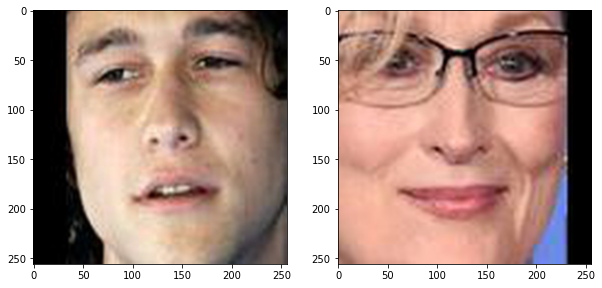

In [99]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(imagea, normalize = True).permute(1, 2, 0)) #a에는 남자
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(imageb, normalize = True).permute(1, 2, 0)) #b은 여자

In [100]:
print(imagea.size())
print(imageb.size())

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [101]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [102]:
start_time = time()
for epoch in range(num_epochs):
  for idx, batch in enumerate(dataloader):
  
    man = batch['A'].to(device)
    woman = batch['B'].to(device)
    optim_disc.zero_grad()
    optim_gen.zero_grad()


    ########discriminator 훈련#################
    
    ##man -> woman
    fake_woman = gen_W(man) #A generator 이용해 horse를 가짜 apple 변환  H -> A
    D_W_real = disc_W(woman) #A discriminator가 진짜 apple 임을 확인
    D_W_fake = disc_W(fake_woman.detach()) #A discriminator가 가짜 apple 확인
    D_W_real_loss = mse(D_W_real, torch.ones_like(D_W_real)) #진짜를 진짜로 인식
    D_W_fake_loss = mse(D_W_fake, torch.zeros_like(D_W_fake)) #가짜를 가짜로 인식
    D_W_loss = D_W_real_loss + D_W_fake_loss # A discriminator 훈련

    ##apple -> fake horse
    fake_man = gen_M(woman) #A-> O
    D_M_real = disc_M(man)
    D_M_fake = disc_M(fake_man.detach())
    D_M_real_loss = mse(D_M_real, torch.ones_like(D_M_real))
    D_M_fake_loss = mse(D_M_fake, torch.zeros_like(D_M_fake))
    D_M_loss = D_M_real_loss + D_M_fake_loss

    D_loss = (D_M_loss + D_W_loss) / 2

    D_loss.backward()
    optim_disc.step()

    ##########generator 학습 #####################

    #adversarial loss 
    D_M_fake = disc_M(fake_man)
    D_W_fake = disc_W(fake_woman)
    loss_G_M = mse(D_M_fake, torch.ones_like(D_M_fake)) #CE 를 쓰지않고 least square Loss 
    loss_G_W = mse(D_W_fake, torch.ones_like(D_W_fake))

    # cycle loss
    cycle_man = gen_M(fake_woman) #바꾼 사과에 대해 다시 말말로 돌아오도록 만든다
    cycle_woman = gen_W(fake_man) #바꾼 말에 대해 다시 사과로 돌아오도록 만든다
    cycle_man_loss = L1(man, cycle_man)
    cycle_woman_loss = L1(woman, cycle_woman)

    #identity loss
    #identity_orange = gen_O(orange)
    #identity_apple = gen_A(apple)
    #identity_orange_loss = L1(orange, identity_orange)
    #identity_apple_loss = L1(apple, identity_apple)

    G_loss = (loss_G_M+ loss_G_W + cycle_man_loss * lambda_cycle + cycle_woman_loss * lambda_cycle)
    G_loss.backward()
    optim_gen.step()
    if idx == 50:
      end_time = time()
      print('EPOCH : ', epoch, 'G_loss : ', G_loss, 'D_loss :', D_loss, 'Time : ', (end_time-start_time) / 60)
      break

  

EPOCH :  0 G_loss :  tensor(4.5694, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4718, device='cuda:0', grad_fn=<DivBackward0>) Time :  0.6447951038678487
EPOCH :  1 G_loss :  tensor(3.9302, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4338, device='cuda:0', grad_fn=<DivBackward0>) Time :  1.2972615838050843
EPOCH :  2 G_loss :  tensor(3.7109, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4352, device='cuda:0', grad_fn=<DivBackward0>) Time :  1.9622975905736288
EPOCH :  3 G_loss :  tensor(2.8152, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4966, device='cuda:0', grad_fn=<DivBackward0>) Time :  2.642002793153127
EPOCH :  4 G_loss :  tensor(3.1049, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.5153, device='cuda:0', grad_fn=<DivBackward0>) Time :  3.3214123169581096
EPOCH :  5 G_loss :  tensor(4.0339, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4937, device='cuda:0', grad_fn=<DivBackward0>) Time :  4.0049

## 모델 저장

In [114]:
os.makedirs('/content/drive/MyDrive/cyclegan_dir')

In [118]:
torch.save(gen_M.state_dict(), './data')
torch.save(gen_W.state_dict(), './data')

In [103]:
man_image = iter(dataloader).next()['A'][1]
woman_image = iter(dataloader).next()['B'][1]

In [104]:
man_image = man_image.to(device)
woman_image = woman_image.to(device)

## 모델에 이미지 넣어서 결과 확인

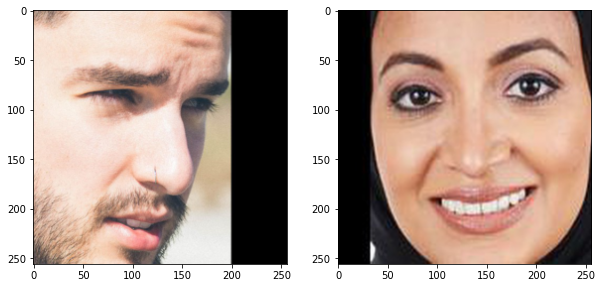

In [105]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(man_image.cpu(), normalize = True).permute(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(woman_image.cpu(), normalize = True).permute(1, 2, 0)) 

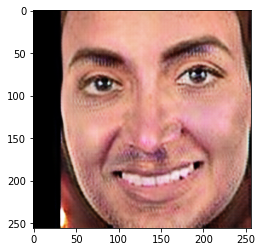

In [107]:
fake_man = gen_M(woman_image).cpu()
plt.imshow(torchvision.utils.make_grid(fake_man.cpu(), normalize = True).permute(1, 2, 0)) 

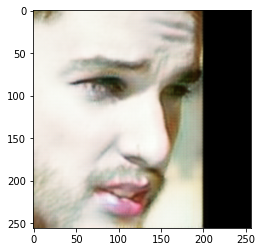

In [108]:
fake_woman = gen_W(man_image).cpu()
plt.imshow(torchvision.utils.make_grid(fake_woman.cpu(), normalize = True).permute(1, 2, 0)) 